# Identifying Differentially Expressed Genes as part of progeny Pathways using pyDeseq2
- Created by: Christian Eger
- Creation date: October 14, 2024
- environment: liana_c2c-env.yml

## Import modules

In [1]:
import scanpy as sc
from pathlib import Path
import decoupler as dc
import pandas as pd
from scipy import sparse
import anndata as ad
import matplotlib.pyplot as plt

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from itertools import product

## Helper Functions

In [2]:
def return_highest_weight_pathway(
        genes: pd.Index,
        progeny_df: pd.DataFrame 
):
    sorted_progeny_df = progeny_df.sort_values(["weight", "target"], ascending=[False, True])
    highest_weight_sources = sorted_progeny_df.drop_duplicates(subset="target", keep="first").set_index("target")["source"]
    return genes.map(lambda gene: highest_weight_sources.get(gene, pd.NA))

def annotate_var_pathways(adata, progeny_df):
    annotated_adata = adata.copy()
    annotated_adata.var = annotated_adata.var.assign(source=lambda x: return_highest_weight_pathway(x.index, progeny_df))
    return annotated_adata

def pseudobulk_from_adata(adata: ad.AnnData) -> ad.AnnData:
    return ad.AnnData(
        X=sparse.csr_matrix(adata.X.toarray().sum(axis=0)),
        obs=adata.obs[filter(lambda column: len(set(adata.obs[column])) == 1, adata.obs.columns)].head(1),
        var=adata.var
    )

## Folder Structure

In [3]:
global_repo_data = Path.cwd() / ".." / ".." / ".data"
local_folder_data = Path.cwd() / ".data"
figures_dir = local_folder_data / "figures"

## Data Loading

In [4]:
adata = sc.read_h5ad(global_repo_data / "Marburg_cell_states_locked_ctl240709.raw.h5ad")
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

In [5]:
net = dc.get_progeny(organism='human')
net

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
1395,p53,CCDC150,-3.174527,7.396252e-13
1396,p53,LCE1A,6.154823,8.475458e-13
1397,p53,TREM2,4.101937,9.739648e-13
1398,p53,GDF9,3.355741,1.087433e-12


## Dataprep for deseq

In [6]:
pseudobulk = ad.concat(map(pseudobulk_from_adata, map(lambda batch: adata[adata.obs["batch"] == batch],set(adata.obs["batch"]))))
pseudobulk = annotate_var_pathways(pseudobulk, net)
pseudobulk.obs = pseudobulk.obs.set_index("batch")
pseudobulk

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['GnR_07_IAV', 'GER12_IAV', 'GER14_IAV', 'CHE01_IAV', 'ST08_GnR_CTRL']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 24 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'condition', 'sample_group', 'group', '_scvi_batch', 'batch-scANVI'
    var: 'source'

In [7]:
counts_df = pd.DataFrame(pseudobulk.X.toarray(), index=pseudobulk.obs_names, columns=pseudobulk.var_names)
metadata = pseudobulk.obs

In [8]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="group", 
    refit_cooks=True,
    inference=inference,
)

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/pydeseq2/dds.py:250: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [9]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.33 seconds.

Fitting dispersion trend curve...
... done in 1.05 seconds.

Fitting MAP dispersions...
... done in 2.88 seconds.

Fitting LFCs...
... done in 1.85 seconds.

Refitting 0 outliers.



In [10]:
stat_res = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: group copd-iav vs copd-ctrl
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG         97.553469        0.242657  0.405928  0.597783  0.549985  0.999977
A1BG-AS1    114.869981        0.035237  0.348778  0.101030  0.919527  0.999977
A1CF         12.514196        0.285898  0.507358  0.563505  0.573091  0.999977
A2M          15.295965        0.341178  0.621533  0.548930  0.583054  0.999977
A2M-AS1      24.533363        0.102426  0.421443  0.243036  0.807978  0.999977
...                ...             ...       ...       ...       ...       ...
ZXDC       2904.026822       -0.096072  0.325264 -0.295367  0.767713  0.999977
ZYG11A       41.986381        0.049089  0.313455  0.156605  0.875556  0.999977
ZYG11B     4038.289916       -0.074527  0.099679 -0.747665  0.454662  0.999977
ZYX       47669.265209        0.081993  0.266293  0.307904  0.758156  0.999977
ZZEF1      1300.648810       -0.102528  0.227795 -0.450091  0.652

... done in 6.94 seconds.



In [11]:
scvi_degs = ['IFIT1',
 'IFIT3',
 'IFI6',
 'MX1',
 'AC006145.1',
 'IFI44L',
 'OAS2',
 'ISG15',
 'XAF1',
 'IFIT2']

In [22]:
type(stat_res)

pydeseq2.ds.DeseqStats

In [21]:
stat_res.results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,97.553469,0.242657,0.405928,0.597783,0.549985,0.999977
A1BG-AS1,114.869981,0.035237,0.348778,0.101030,0.919527,0.999977
A1CF,12.514196,0.285898,0.507358,0.563505,0.573091,0.999977
A2M,15.295965,0.341178,0.621533,0.548930,0.583054,0.999977
A2M-AS1,24.533363,0.102426,0.421443,0.243036,0.807978,0.999977
...,...,...,...,...,...,...
ZXDC,2904.026822,-0.096072,0.325264,-0.295367,0.767713,0.999977
ZYG11A,41.986381,0.049089,0.313455,0.156605,0.875556,0.999977
ZYG11B,4038.289916,-0.074527,0.099679,-0.747665,0.454662,0.999977
ZYX,47669.265209,0.081993,0.266293,0.307904,0.758156,0.999977


In [12]:
res = stat_res.results_df
res = res.assign(source=lambda x: return_highest_weight_pathway(x.index, net))
res = res[~res["source"].isna()]
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,source
ABCA12,725.599944,-0.059260,0.265813,-0.222938,0.823583,0.999977,p53
ABCA6,130.741780,-0.269353,0.385778,-0.698206,0.485048,0.999977,TGFb
ABCA8,14.533171,0.599503,0.517971,1.157408,0.247106,0.999977,TGFb
ABCC4,1984.471239,-0.310524,0.411213,-0.755142,0.450164,0.999977,Androgen
ABCC5,4861.518093,-0.200580,0.150201,-1.335414,0.181741,0.999977,Estrogen
...,...,...,...,...,...,...,...
ZNF99,10.687485,-0.499837,0.393265,-1.270993,0.203731,0.999977,Trail
ZNFX1,10403.049912,0.984083,0.203271,4.841247,0.000001,0.000302,JAK-STAT
ZSCAN2,509.205637,-0.137665,0.200194,-0.687661,0.491666,0.999977,PI3K
ZSCAN31,5325.462581,-0.200867,0.375047,-0.535578,0.592250,0.999977,EGFR


In [13]:
pd.DataFrame(list(set(list(res.query("padj < 0.05").index)) & set(scvi_degs))).set_index(0)

""
0
OAS2
ISG15
IFI44L
IFIT2
XAF1
IFIT1
IFIT3
IFI6
MX1


In [14]:
scvi_pydeseq_deg_intersection = list(set(list(res.query("padj < 0.05").index)) & set(scvi_degs))
scvi_pydeseq_deg_intersection

['OAS2', 'ISG15', 'IFI44L', 'IFIT2', 'XAF1', 'IFIT1', 'IFIT3', 'IFI6', 'MX1']

In [15]:
pd.DataFrame(scvi_pydeseq_deg_intersection).set_index(0).assign(source=lambda x: return_highest_weight_pathway(x.index, net))

,source
0,
OAS2,JAK-STAT
ISG15,JAK-STAT
IFI44L,JAK-STAT
IFIT2,JAK-STAT
XAF1,JAK-STAT
IFIT1,JAK-STAT
IFIT3,JAK-STAT
IFI6,JAK-STAT
MX1,JAK-STAT


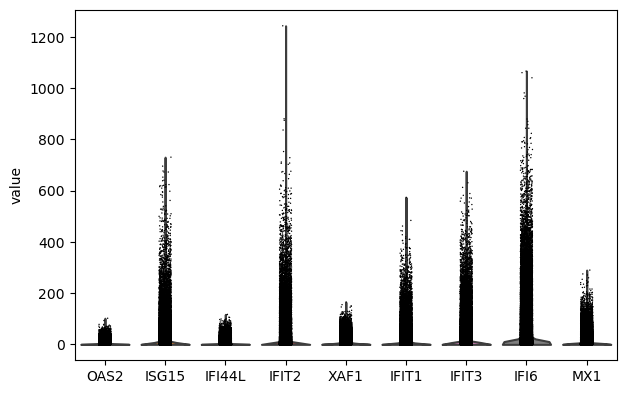

In [16]:
sc.pl.violin(adata, scvi_pydeseq_deg_intersection)

## Results

In [17]:
combinations((12,3,3), (2,3,3))

NameError: name 'combinations' is not defined

In [ ]:

{condition: gene for condition, gene in product(set(adata.obs["group"]), scvi_pydeseq_deg_intersection)}

{'healthy_ctrl': 'IFI44L',
 'copd_ctrl': 'IFI44L',
 'healthy_iav': 'IFI44L',
 'copd_iav': 'IFI44L'}

In [ ]:
adata[adata.obs["group"] == "healthy_ctrl"][:, "IFIT3"].X.sum()

37154.0

In [ ]:
adata.obs

,sex,age,ethnicity,PaCO2,donor,infection,disease,SMK,illumina_stimunr,bd_rhapsody,...,cell_states,leiden,cell_compartment,_scvi_batch,_scvi_labels,C_scANVI,viral_counts,infected_status,seed_labels,batch-scANVI
493638-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,CSE-07,CTRL,COPD,7,21_0017,1,...,OMG+Ciliated,MultiC_0,Ciliated,9,18,OMG+Ciliated,23.0,Uninfected,OMG+Ciliated,reference
816750-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,CSE-07,CTRL,COPD,7,21_0017,1,...,APOD+Ciliated,MultiC_1,Ciliated,9,0,APOD+Ciliated,20.0,Uninfected,APOD+Ciliated,reference
678000-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,CSE-07,CTRL,COPD,7,21_0017,1,...,TCN1+Club,MultiC_3,Club,9,26,TCN1+Club,19.0,Uninfected,TCN1+Club,reference
247802-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,CSE-07,CTRL,COPD,7,21_0017,1,...,TCN1+Club,MultiC_3,Club,9,26,TCN1+Club,16.0,Uninfected,TCN1+Club,reference
177433-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,CSE-07,CTRL,COPD,7,21_0017,1,...,TCN1+Club,MultiC_3,Club,9,26,TCN1+Club,17.0,Uninfected,TCN1+Club,reference
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5327279-GER02_IAV-V6,male,53,caucasian,71.1,GER-02,IAV,healthy,6,21_0507,6,...,SERPINE1+Basal,Mixed_3,Basal,6,36,SERPINE1+Basal,35.0,Uninfected,Unknown,query
10502482-GER02_IAV-V6,male,53,caucasian,71.1,GER-02,IAV,healthy,6,21_0507,6,...,SERPINE1+Basal,Mixed_3,Basal,6,36,SERPINE1+Basal,12.0,Uninfected,Unknown,query
13574786-GER02_IAV-V6,male,53,caucasian,71.1,GER-02,IAV,healthy,6,21_0507,6,...,DHRS9+Club,Mixed_1,Club,6,36,DHRS9+Club,129.0,Uninfected,Unknown,query
3396934-GER02_IAV-V6,male,53,caucasian,71.1,GER-02,IAV,healthy,6,21_0507,6,...,MHCII+Club,Mixed_0,Club,6,36,MHCII+Club,22.0,Uninfected,Unknown,query


In [ ]:
{set(adata.obs["group"])}

In [ ]:
for condition

In [ ]:
adata[:, scvi_pydeseq_deg_intersection]

View of AnnData object with n_obs × n_vars = 97573 × 9
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

In [ ]:
res.query("padj < 0.05").sort_values("log2FoldChange", ascending=False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,source
CXCL11,9808.685574,5.373316,0.704347,7.628790,2.369673e-14,1.238655e-11,NFkB
RSAD2,14702.261424,5.197308,0.423273,12.278865,1.176374e-34,3.197502e-31,JAK-STAT
IFIT1,46420.526268,4.988218,0.361353,13.804284,2.401476e-43,1.631863e-39,JAK-STAT
OASL,8581.694380,4.712131,0.508209,9.272025,1.826446e-20,1.504383e-17,JAK-STAT
IFIT2,57399.392090,4.646008,0.394006,11.791730,4.306031e-32,8.360160e-29,JAK-STAT
...,...,...,...,...,...,...,...
ADAR,14833.468986,0.754414,0.140604,5.365542,8.070667e-08,2.193688e-05,JAK-STAT
RNF19B,11484.769867,0.675199,0.149663,4.511454,6.438467e-06,1.356620e-03,NFkB
PSMB8,9512.155590,0.576518,0.151116,3.815082,1.361375e-04,2.202591e-02,JAK-STAT
TRIM38,10952.654845,0.567782,0.133981,4.237776,2.257444e-05,4.358586e-03,JAK-STAT


<Axes: >

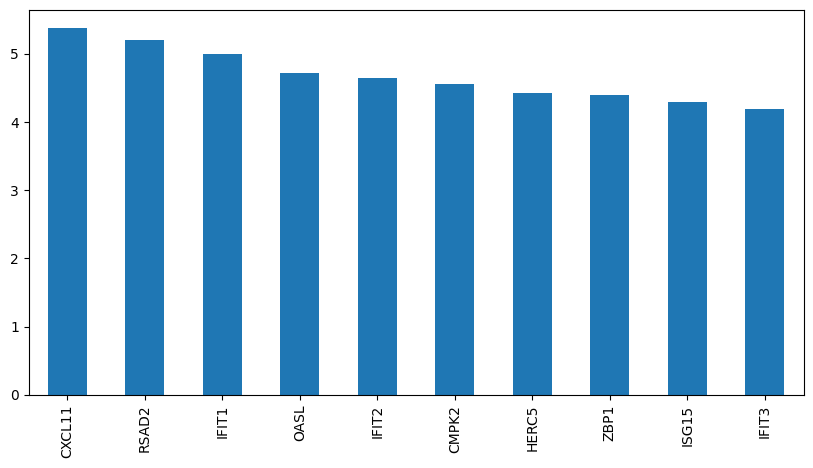

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))
res.query("padj < 0.05").sort_values("log2FoldChange", ascending=False)["log2FoldChange"].head(10).plot(kind="bar")


In [ ]:
set(res.query("padj < 0.05").sort_values("log2FoldChange", ascending=False)["log2FoldChange"].head(10).index)

{'CMPK2',
 'CXCL11',
 'HERC5',
 'IFIT1',
 'IFIT2',
 'IFIT3',
 'ISG15',
 'OASL',
 'RSAD2',
 'ZBP1'}

In [ ]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

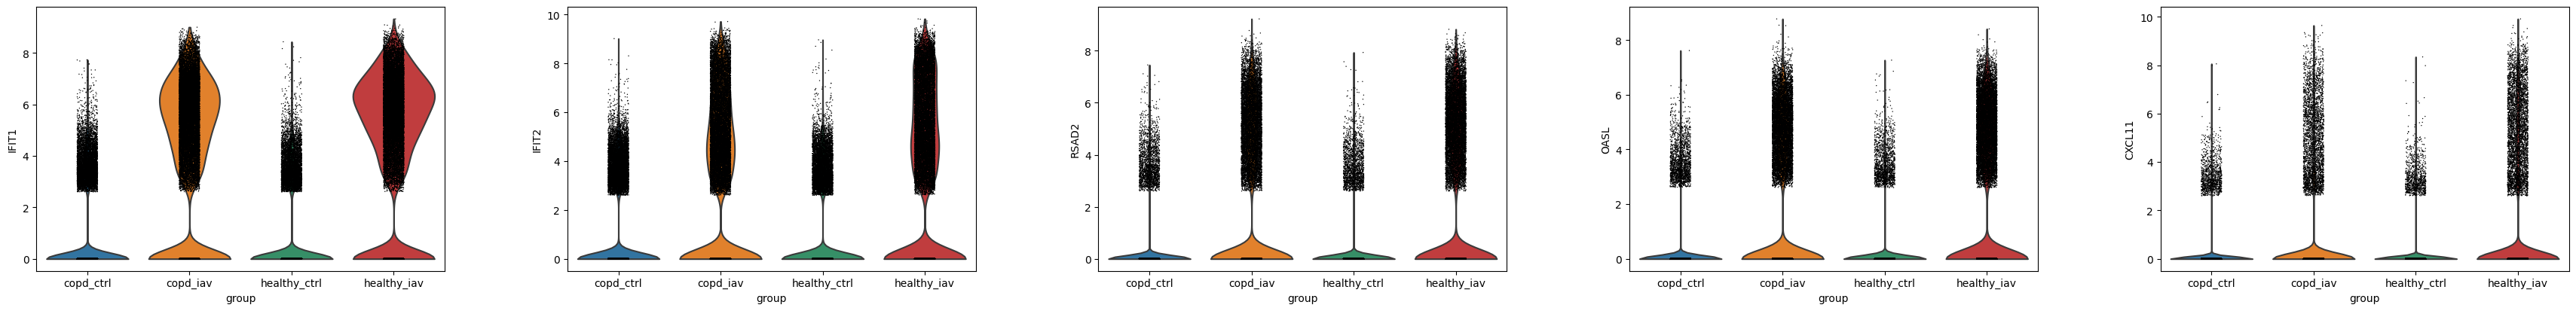

In [ ]:
genes_of_interest = set(res.query("padj < 0.05").sort_values("log2FoldChange", ascending=False)["log2FoldChange"].head(5).index)
sc.pl.violin(adata, genes_of_interest, groupby="group", save=figures_dir / "deseq_expression_violin_group.svg")

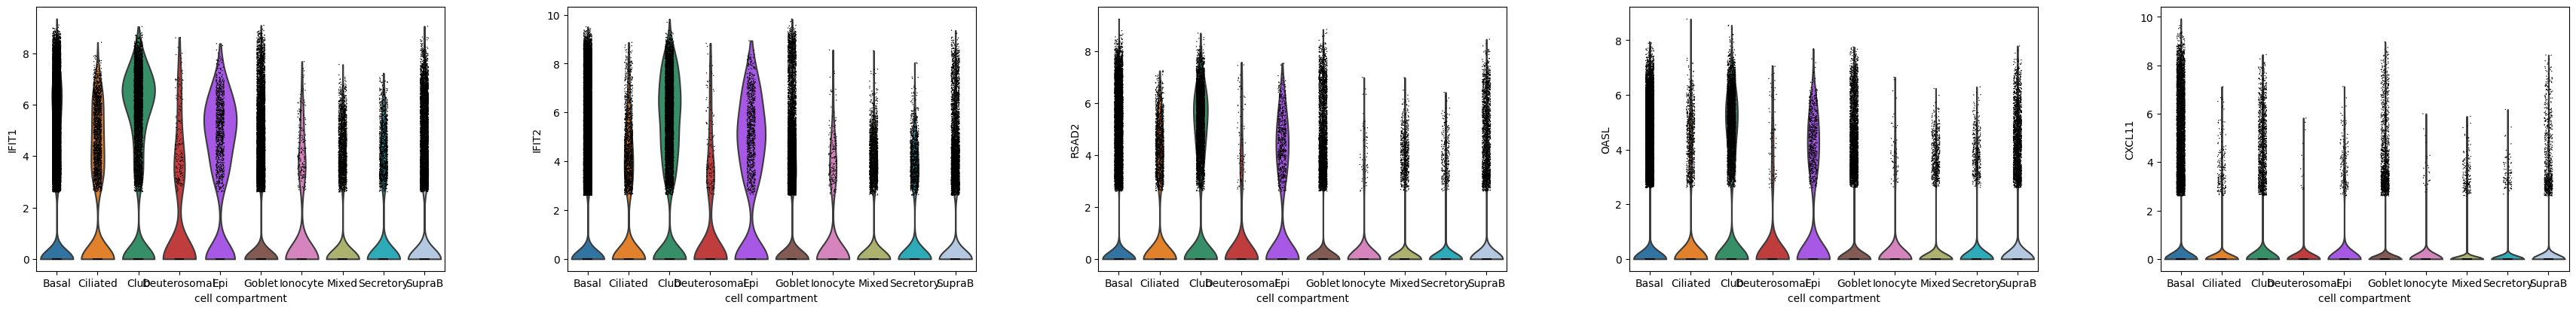

In [ ]:
sc.pl.violin(adata, genes_of_interest, groupby="cell_compartment", save=figures_dir / "deseq_expression_violin_compartment.svg")

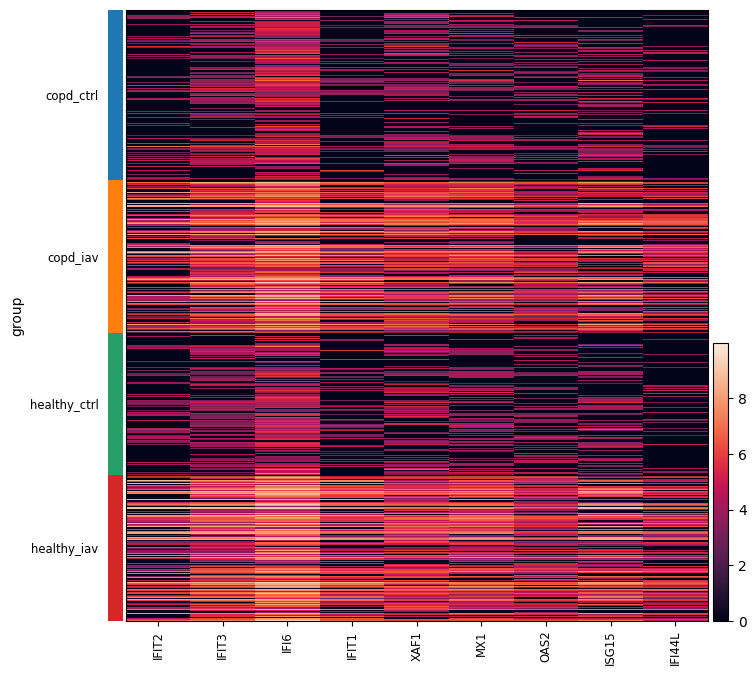

In [ ]:
sc.pl.heatmap(adata, scvi_pydeseq_deg_intersection, groupby="group", figsize=(8,8), cmap="rocket")

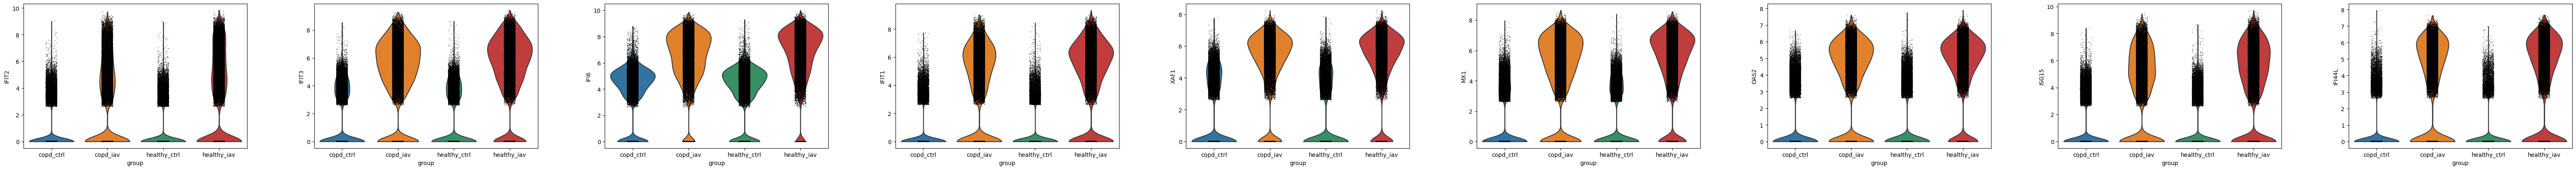

In [ ]:
sc.pl.violin(adata, scvi_pydeseq_deg_intersection, groupby="group")